In [35]:
!pip install simpledbf
!pip install geopandas
import geopandas as gpd
from google.colab import drive
from scipy.interpolate import interp2d
import pandas as pd
import datetime
import time
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy.interpolate import pchip_interpolate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Open the dataframe

In [37]:
# start the time
startTime = time.time()

In [38]:
df = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Agrimonia/Bovini/Bovini.shp')
df['DATE'] = pd.to_datetime(df['DATE'], format='%d-%b-%Y')
df.rename(columns = {'DATE':'Date'}, inplace = True)
df = pd.DataFrame(df)
print(type(df))

#Calculate the density
operation = df['NUMEROCAPI']/(df['Shape_Area'])
df['NUMEROCAPI'] = operation*pow(10,6)
df = df.loc[(df['COD_REG'] == 1) | (df['COD_REG'] == 3)|(df['COD_REG'] == 4) | (df['COD_REG'] == 5) |(df['COD_REG'] == 8)]
df.rename(columns = {'NUMEROCAPI':'DENSITY',}, inplace = True)

pd.set_option('display.max_columns', None)
df.head()

<class 'pandas.core.frame.DataFrame'>


,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,Shape_Area,Shape_Leng,CenterX,CenterY,TYPEINT,DENSITY,NALLEVAMENT,BOVINI,BUFALINI,Date,geometry
0,1,1,1,201,201,1077,001077,Chiaverano,None,0,1.202212e+07,18164.236621,414253.041314,5.039521e+06,0,5.157161,9,62,0,2015-12-31,"POLYGON ((414358.390 5042001.044, 414381.796 5..."
1,1,1,1,201,201,1079,001079,Chiesanuova,None,0,4.118911e+06,10777.318814,394197.394664,5.030811e+06,0,66.036874,7,272,0,2015-12-31,"POLYGON ((394621.039 5031581.116, 394716.100 5..."
2,1,1,1,201,201,1089,001089,Coazze,None,0,5.657268e+07,41591.122092,360808.802237,4.990104e+06,0,1.484816,5,84,0,2015-12-31,"POLYGON ((364914.897 4993224.894, 364929.991 4..."
3,1,1,1,201,201,1006,001006,Almese,None,0,1.787564e+07,17058.439037,375721.501086,4.997294e+06,0,12.642906,21,226,0,2015-12-31,"POLYGON ((376934.962 4999073.854, 376960.555 4..."
4,1,1,1,201,201,1007,001007,Alpette,None,0,5.626076e+06,9795.562269,388609.910901,5.029096e+06,0,0.000000,0,0,0,2015-12-31,"POLYGON ((388890.737 5030465.123, 388945.987 5..."


In [39]:
df.drop(['NALLEVAMENT', 'BOVINI', 'BUFALINI'], axis=1)
df.head()

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,Shape_Area,Shape_Leng,CenterX,CenterY,TYPEINT,DENSITY,NALLEVAMENT,BOVINI,BUFALINI,Date,geometry
0,1,1,1,201,201,1077,001077,Chiaverano,None,0,1.202212e+07,18164.236621,414253.041314,5.039521e+06,0,5.157161,9,62,0,2015-12-31,"POLYGON ((414358.390 5042001.044, 414381.796 5..."
1,1,1,1,201,201,1079,001079,Chiesanuova,None,0,4.118911e+06,10777.318814,394197.394664,5.030811e+06,0,66.036874,7,272,0,2015-12-31,"POLYGON ((394621.039 5031581.116, 394716.100 5..."
2,1,1,1,201,201,1089,001089,Coazze,None,0,5.657268e+07,41591.122092,360808.802237,4.990104e+06,0,1.484816,5,84,0,2015-12-31,"POLYGON ((364914.897 4993224.894, 364929.991 4..."
3,1,1,1,201,201,1006,001006,Almese,None,0,1.787564e+07,17058.439037,375721.501086,4.997294e+06,0,12.642906,21,226,0,2015-12-31,"POLYGON ((376934.962 4999073.854, 376960.555 4..."
4,1,1,1,201,201,1007,001007,Alpette,None,0,5.626076e+06,9795.562269,388609.910901,5.029096e+06,0,0.000000,0,0,0,2015-12-31,"POLYGON ((388890.737 5030465.123, 388945.987 5..."


In [40]:
#count rows
count = df.shape
print(count)

(50206, 21)


# Extract informations

In [41]:
temp = df.loc[:,['PRO_COM']]
print(temp.size)
temp.head()

50206


,PRO_COM
0,1077
1,1079
2,1089
3,1006
4,1007


In [42]:
list = temp.PRO_COM.unique()
count_unique = df['PRO_COM'].nunique()  

print(list)
print(type(list))
print("Number of unique cities: ",count_unique)

[ 1077  1079  1089 ... 15251 22254 97008]
<class 'numpy.ndarray'>
Number of unique cities:  3862


# Select the values

In [43]:
table_to_examine = df.loc[df['PRO_COM'] == 1077]
print(table_to_examine.shape)
table_to_examine.head()


(13, 21)


,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,Shape_Area,Shape_Leng,CenterX,CenterY,TYPEINT,DENSITY,NALLEVAMENT,BOVINI,BUFALINI,Date,geometry
0,1,1,1,201,201,1077,001077,Chiaverano,None,0,1.202212e+07,18164.236621,414253.041314,5.039521e+06,0,5.157161,9,62,0,2015-12-31,"POLYGON ((414358.390 5042001.044, 414381.796 5..."
7904,1,1,1,201,201,1077,001077,Chiaverano,None,0,1.202212e+07,18164.236621,414253.041314,5.039521e+06,0,4.990801,8,60,0,2016-06-30,"POLYGON ((414358.390 5042001.044, 414381.796 5..."
15808,1,1,1,201,201,1077,001077,Chiaverano,None,0,1.202212e+07,18164.236621,414253.041314,5.039521e+06,0,5.489881,8,66,0,2016-12-31,"POLYGON ((414358.390 5042001.044, 414381.796 5..."
23712,1,1,1,201,201,1077,001077,Chiaverano,None,0,1.202212e+07,18164.236621,414253.041314,5.039521e+06,0,5.073981,8,61,0,2017-06-30,"POLYGON ((414358.390 5042001.044, 414381.796 5..."
31616,1,1,1,201,201,1077,001077,Chiaverano,None,0,1.202212e+07,18164.236621,414253.041314,5.039521e+06,0,4.824441,8,58,0,2017-12-31,"POLYGON ((414358.390 5042001.044, 414381.796 5..."


In [44]:
#Extract the single line
line = table_to_examine.loc[0:1,'COD_RIP':'TYPEINT']
line.head()

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,Shape_Area,Shape_Leng,CenterX,CenterY,TYPEINT
0,1,1,1,201,201,1077,001077,Chiaverano,None,0,1.202212e+07,18164.236621,414253.041314,5.039521e+06,0


## Functions

### Missing rows

In [45]:

def fill_missing_rows(df, column, fillwith):
    '''
    Fills the rows of a specific column with a provided list of values.
    Parameters:
        df       (DataFrame)  : The DataFrame to be filled
        column      (string)  : The target column
        fillwith      (list)  : The list of values to fill the column with
    
    Returns:
        df       (DataFrame)  : The filled DataFrame
    '''
    df = df.set_index(column).reindex(pd.Index(fillwith))

    df.reset_index(inplace=True)

    df = df.rename(columns={'index': column})

    return df

### Mising dates

In [46]:
def fill_missing_dates(df, start, end, freq='d', column='Date'):    
    '''
    Fills the rows of a specific column with the dates between start and end and with a given frequency.
    Parameters:
        df      (DataFrame) : The DataFrame to be filled
        column     (string) : The target column
        start      (string) : The time interval start date
        end        (string) : The time interval end date
        freq       (string) : The frequency of the date ranging
    
    Returns:
        df      (DataFrame) : The filled DataFrame 
    '''
    index = pd.Index(pd.date_range(start, end, freq=freq))

    if len(df) < len(index):

        df[column] = pd.to_datetime(df[column])

        df = fill_missing_rows(df, column, index)

        assert(len(df) == len(index))

    return df

### Interpolation

In [47]:
def upsample(df, column, start, end, fillna=False):
    '''
    Upsamples the time series by augmenting the DataFrame with the missing dates and interpolating them.
    Parameters:
        df    (DataFrame) : The DataFrame containing the time series to be upsampled
        column   (string) : The column name of the DataFrame where the time series is located
        start    (string) : The time interval start date
        end      (string) : The time interval end date
        fillna  (boolean) : If True fills the remaining missing values
    Returns:
        filled_df (DataFrame) : The DataFrame with the upsampled time series at the specified column
    '''
    filled_df = fill_missing_dates(df, start, end, freq='d', column='Date')
    filled_df[column] = filled_df[column].interpolate()

    if fillna: filled_df[column] = filled_df[column].fillna(method='ffill').fillna(method='bfill')

    return filled_df


### Interpolate chip

In [48]:
def interpolatepchip(table_to_examine):
  result = fill_missing_dates(table_to_examine, '2015-12-31', '2021-12-31')
  allDates = result['Date']
  y = pchip_interpolate(table_to_examine['Date'], table_to_examine['DENSITY'], allDates)
  template = table_to_examine.iloc[0:1,0:21]
  n = result.shape[0]
  df_repeated = pd.concat([template]*n, ignore_index=True)
  df_repeated['Date'] = allDates 
  df_repeated['Density'] = y 
  df_repeated.drop(df_repeated.columns[15], axis=1, inplace=True)
  return df_repeated

## Call functions

In [49]:
dfresult = interpolatepchip(table_to_examine)
dfresult.drop(dfresult.columns[14:18], axis=1, inplace=True)
print(type(dfresult))
print(dfresult.shape)

dfresult.head()

<ipython-input-46-d8c1033fdc5d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_datetime(df[column])


<class 'pandas.core.frame.DataFrame'>
(2193, 17)


,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,PRO_COM,PRO_COM_T,COMUNE,COMUNE_A,CC_UTS,Shape_Area,Shape_Leng,CenterX,CenterY,Date,geometry,Density
0,1,1,1,201,201,1077,001077,Chiaverano,None,0,1.202212e+07,18164.236621,414253.041314,5.039521e+06,2015-12-31,"POLYGON ((414358.390 5042001.044, 414381.796 5...",5.157161
1,1,1,1,201,201,1077,001077,Chiaverano,None,0,1.202212e+07,18164.236621,414253.041314,5.039521e+06,2016-01-01,"POLYGON ((414358.390 5042001.044, 414381.796 5...",5.154458
2,1,1,1,201,201,1077,001077,Chiaverano,None,0,1.202212e+07,18164.236621,414253.041314,5.039521e+06,2016-01-02,"POLYGON ((414358.390 5042001.044, 414381.796 5...",5.151785
3,1,1,1,201,201,1077,001077,Chiaverano,None,0,1.202212e+07,18164.236621,414253.041314,5.039521e+06,2016-01-03,"POLYGON ((414358.390 5042001.044, 414381.796 5...",5.149141
4,1,1,1,201,201,1077,001077,Chiaverano,None,0,1.202212e+07,18164.236621,414253.041314,5.039521e+06,2016-01-04,"POLYGON ((414358.390 5042001.044, 414381.796 5...",5.146526


# Print the result

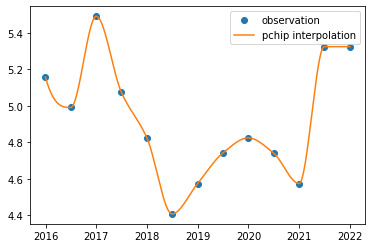

In [50]:
plt.plot(table_to_examine['Date'], table_to_examine['DENSITY'], "o", label="observation")
plt.plot(dfresult['Date'], dfresult['Density'], label="pchip interpolation")
plt.legend()
plt.show()

# Measure time 

In [51]:
dfresult.to_csv('/content/drive/MyDrive/Colab Notebooks/Agrimonia/Bovini/resultBoviniAgrimoniaMono.csv')

In [52]:

executionTime = (time.time() - startTime)/60
print('Execution time in minutes: ' + str(executionTime))

Execution time in minutes: 0.7049178163210551
